# Проверка работоспособности метода на случайных матрицах

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tf2onnx.convert import from_keras

keras_model = load_model('./recognition_model.h5', compile=False)

keras_model.input, keras_model.output

(<KerasTensor: shape=(None, 32, 400, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 50, 80) dtype=float32 (created by layer 'dense_1')>)

In [4]:
import tensorflow as tf

spec = (tf.TensorSpec(keras_model.input.shape, tf.float32, name="image_data"),)
# tf.TensorSpec(keras_model.input[1].shape, tf.float32, name="image_data"),
output_path = "./recognition_model.onnx"

In [5]:
model_proto, external_tensor_storage = from_keras(keras_model, input_signature=spec, output_path=output_path)

In [18]:
output_names = [n.name for n in model_proto.graph.output]
output_names

['dense_3']

In [19]:
import numpy as np

input_dict = {'image_data': np.random.rand(1, 32, 400, 1).astype('float32')}

In [20]:
import onnxruntime as rt

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred = m.run(output_names, input_dict)

In [21]:
onnx_pred[0].shape

(1, 50, 46)

In [22]:
m.run(output_names, {inp.name: np.random.rand(1, *inp.shape[1:]).astype('float32') for  inp in m.get_inputs()})

[array([[[7.08475227e-06, 1.04100685e-07, 1.55010116e-06, ...,
          6.66607230e-06, 4.08481185e-07, 9.99611199e-01],
         [6.74374693e-04, 1.60419404e-05, 6.57260171e-06, ...,
          1.12501681e-02, 5.93225632e-05, 4.41714772e-04],
         [3.10218986e-03, 2.83802110e-05, 4.52121349e-05, ...,
          8.47554649e-04, 6.23951855e-05, 7.61206686e-01],
         ...,
         [8.56728293e-04, 6.78597367e-04, 5.90285636e-05, ...,
          3.52039444e-03, 7.75435692e-05, 7.71246731e-01],
         [2.06666649e-04, 3.16864098e-05, 8.50708784e-06, ...,
          1.27828913e-04, 7.13421286e-06, 9.90641057e-01],
         [2.91970646e-04, 5.07977209e-04, 4.69130973e-05, ...,
          2.57315021e-02, 2.95961188e-04, 1.61962379e-02]]], dtype=float32)]

# Проверка на реальных данных: замеры скорости и точности

In [93]:
import h5py

with h5py.File('./ocr_segments_gray.hdf5') as f:
    category_data = f['category'][:]
    data = f['data'][:]
    labels = f['label'][:]
    
category_data.shape, data.shape, labels.shape

((18560,), (18560, 32, 400), (18560, 14))

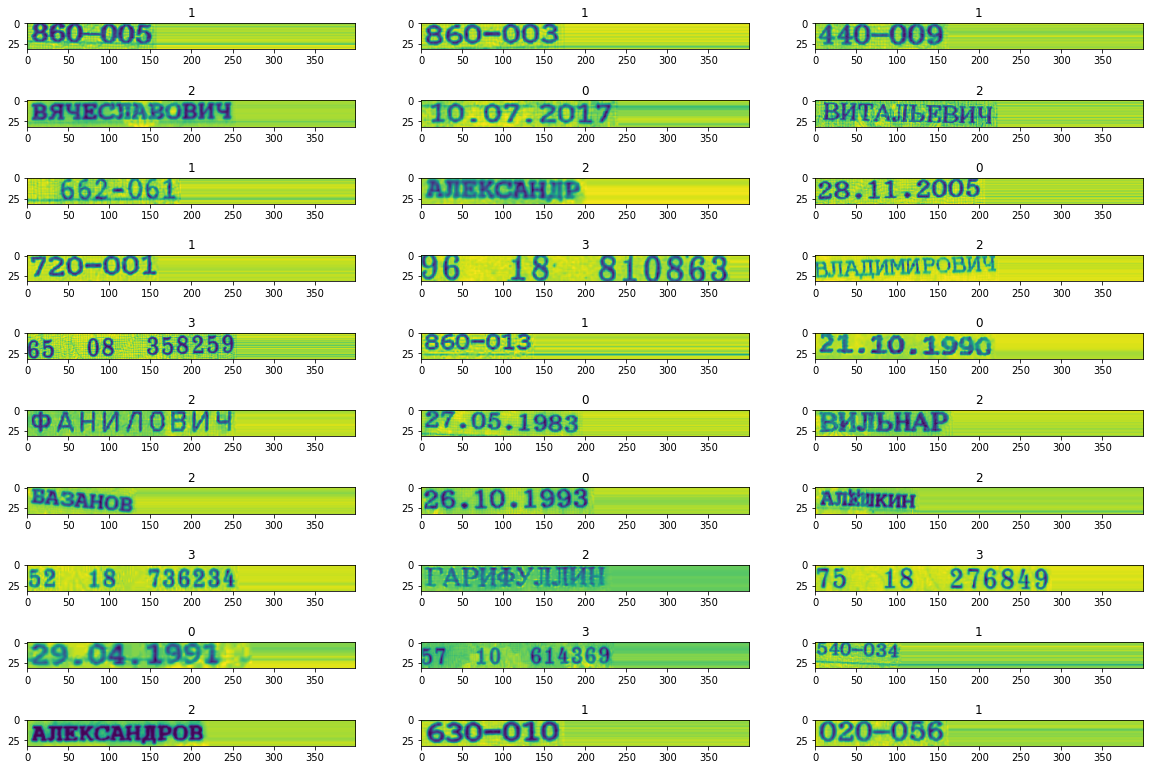

In [94]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(ncols=3, nrows=10, figsize=(20, 14))

for i in range(30):
    idx = random.randint(0, category_data.shape[0])
    
    axes[i // 3, i % 3].imshow(data[idx])
    axes[i // 3, i % 3].set_title(f'{str(category_data[idx])}')

In [183]:
category_data_transformed = np.zeros((category_data.shape[0], np.unique(category_data).shape[0]))
category_data_transformed[np.arange(category_data.shape[0]), category_data] = 1
category_data_transformed = np.expand_dims(category_data_transformed, axis=1)
category_data_transformed = np.repeat(category_data_transformed, 50, axis=1)
# category_data_transformed = np.tile(category_data_transformed, math.ceil(128 / 4))[:, :128]

print(category_data_transformed.shape)

(18560, 50, 4)


In [89]:
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras import backend as K

class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')
        
        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

def num_to_label(num, alphabet):
    return "".join([alphabet[e] for e in num if e != -1])

def calc_confidence(num, alphabet):
    confidence = [max(num[j, :]) for j in range(num.shape[0]) if np.argmax(num[j, :]) != len(alphabet)]
    return int(np.mean(confidence) * 100) if len(confidence) else 0

def decode_texts(nums, alphabet):
    values = get_value(ctc_decode(nums, input_length=np.ones(nums.shape[0]) * nums.shape[1], greedy=True)[0][0])
    return [[num_to_label(e[e >= 0], alphabet), calc_confidence(nums[i], alphabet)] for i, e in enumerate(values)]

Mean time per img (ms): 51.5014, CER: 0.030000001192092896
Mean time per img (ms): 31.1475, CER: 0.030000001192092896
Mean time per img (ms): 22.2991, CER: 0.030000001192092896
Mean time per img (ms): 13.0768, CER: 0.020000001415610313
Mean time per img (ms): 9.0783, CER: 0.015000000596046448
Mean time per img (ms): 5.9087, CER: 0.01718750037252903
Mean time per img (ms): 4.9883, CER: 0.022031249478459358



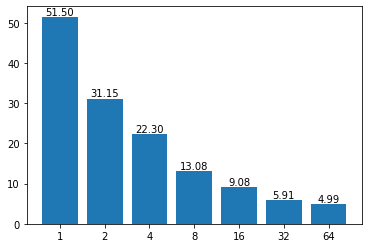

In [153]:
import time

n_batches = 10

batch_stats = dict()

for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    time_taken = 0

    cer_metric_ = CERMetric()

    # warmup
    keras_model.predict([np.random.rand(1, 50, 128).astype('float32'), 
                         np.random.rand(1, 32, 400, 1).astype('float32')])

    for i in range(n_batches):
        img_data_batch = data[i*batch_size: (i+1)*batch_size] / 255
        category_data_batch = category_data_transformed[i*batch_size: (i+1)*batch_size]

        start = time.time()
        predicts = keras_model.predict([category_data_batch, img_data_batch])
        time_taken += time.time() - start

        cer_metric_.update_state(labels[i*batch_size: (i+1)*batch_size].astype('int64'), predicts)

    print(f'Mean time per img (ms): {round(time_taken / n_batches / batch_size * 1000, 4)}, CER: {cer_metric_.result()}')
    batch_stats[batch_size] = round(time_taken / n_batches / batch_size * 1000, 4)
    
fig, ax = plt.subplots()

bars = ax.bar(range(len(batch_stats.keys())), batch_stats.values())
ax.set_xticks(range(len(batch_stats.keys())), labels=[1, 2, 4, 8, 16, 32, 64])
ax.bar_label(bars, fmt='%.2f')
print()

Mean time per img (ms): 3.2996, CER: 0.030000001192092896
Mean time per img (ms): 2.3501, CER: 0.030000001192092896
Mean time per img (ms): 1.9308, CER: 0.030000001192092896
Mean time per img (ms): 2.5288, CER: 0.020000001415610313
Mean time per img (ms): 2.0664, CER: 0.015000000596046448
Mean time per img (ms): 2.2634, CER: 0.01718750037252903
Mean time per img (ms): 2.1328, CER: 0.022031249478459358



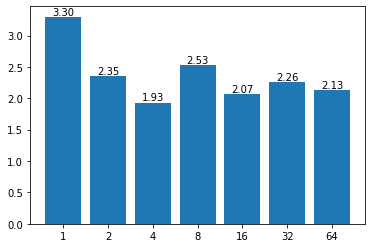

In [154]:
import time

n_batches = 10

batch_stats = dict()

for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    time_taken = 0

    cer_metric_ = CERMetric()
    providers = ['CPUExecutionProvider']
    m = rt.InferenceSession(output_path, providers=providers)

    # warmup
    m.run(output_names, {'field_data': np.random.rand(1, 50, 128).astype('float32'),
                                    'image_data': np.random.rand(1, 32, 400, 1).astype('float32')})[0]

    for i in range(n_batches):
        img_data_batch = np.expand_dims(data[i*batch_size: (i+1)*batch_size] / 255, -1)
        category_data_batch = category_data_transformed[i*batch_size: (i+1)*batch_size]

        input_dict = {'image_data': img_data_batch.astype('float32'), 
                      'field_data': category_data_batch.astype('float32')}

        start = time.time()
        predicts = m.run(output_names, input_dict)[0]
        time_taken += time.time() - start

        cer_metric_.update_state(labels[i*batch_size: (i+1)*batch_size].astype('int64'), predicts)

    print(f'Mean time per img (ms): {round(time_taken / n_batches / batch_size * 1000, 4)}, CER: {cer_metric_.result()}')
    batch_stats[batch_size] = round(time_taken / n_batches / batch_size * 1000, 4)
    
fig, ax = plt.subplots()

bars = ax.bar(range(len(batch_stats.keys())), batch_stats.values())
ax.set_xticks(range(len(batch_stats.keys())), labels=[1, 2, 4, 8, 16, 32, 64])
ax.bar_label(bars, fmt='%.2f')
print()

# Выводы

**Размеры пакетов**

* Tensorflow + Keras с зависямостями около 1 ГБ
* onnxruntime с зависямостями около 30 МБ

**Точность**

Отличий нет

**Скорость inference**

* Для tf+keras сильно зависит от batch_size, средняя = 20мс/картинка
* Для onnxruntime зависимость от batch_size на грани погрешности, средняя = 2.5 мс/картинка


**Итого**

Используем onnx и все

# Конвертация второй модели

In [155]:
keras_model = load_model('./mrz_valid_gray.h5', compile=False)

keras_model.input, keras_model.output

([<KerasTensor: shape=(None, 100, 128) dtype=float32 (created by layer 'input_9')>,
  <KerasTensor: shape=(None, 32, 800, 1) dtype=float32 (created by layer 'input_10')>],
 <KerasTensor: shape=(None, 100, 37) dtype=float32 (created by layer 'dense_4')>)

In [156]:
spec = (tf.TensorSpec((None, 100, 128), tf.float32, name="field_data"),
        tf.TensorSpec((None, 32, 800, 1), tf.float32, name="image_data"),)

output_path = "./mrz_segments_crnn_gray.onnx"

In [157]:
model_proto, external_tensor_storage = from_keras(keras_model, input_signature=spec, output_path=output_path)